## Adaboost

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import pandas
import numpy

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
import root_pandas
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier

### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_train_10000.root' already there; not retrieving.


In [4]:
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_train_100000.root' already there; not retrieving.


In [5]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

In [6]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_test.root' already there; not retrieving.


### Read the smallest part of training file and test file

In [7]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
data1 = pandas.DataFrame(root_numpy.root2array('datasets/public_train_100000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

In [8]:
data.head()
#data.shape
#data['lepton_pt']
#data['sum_pt'] = data['lepton_pt']+data['mem_pt']+data['jet1_pt']+data['jet2_pt']+data['jet3_pt']+data['jet4_pt']
#pt_features = list(filter(lambda feature: feature.endswith("_pt"), features.columns))
#print(pt_features)
#pandas.options.display.max_columns = 40
data.shape

#print data[1:3]
#print data1[1:3]

(10000, 30)

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.


In [9]:
test.head()

,event_id,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,58.814354,-1.223199,1.290717,26.435696,2.608772,68.413330,0.639561,-1.226549,1.000008,...,-1.195189,1.767687,0.000000,72.190338,170.810608,78.644196,224.813538,95.737434,372.835388,469.654236
1,2,21.390781,-0.468277,-1.371404,57.185963,1.214130,118.127953,-0.113784,-2.182008,0.000000,...,0.965376,2.698023,1.000000,62.736309,215.426300,73.971413,211.729141,195.910385,310.480103,431.597137
2,3,58.570217,1.443092,0.105191,54.450954,-2.354347,26.443583,-1.911658,1.337635,0.000000,...,-2.212247,-2.609508,0.000000,48.172768,163.506821,106.111038,260.643646,351.328644,638.053040,790.960815
3,4,70.469345,0.166176,-1.962429,38.138966,2.564890,42.678413,-1.256608,-0.276156,2.000000,...,-0.007441,3.048725,2.000023,99.099815,158.532227,79.701500,169.550491,96.056900,305.073212,402.656067
4,5,113.456779,0.232503,2.941150,64.401146,1.125812,164.289139,-0.735258,-0.590741,1.999937,...,-0.943712,1.599526,2.000023,50.816051,200.099945,130.013855,187.637009,142.145920,433.032440,507.496399


### Define training features

Exclude `event_id`, `target` from the features set

In [10]:
All_features = list(set(data.columns) - {'event_id', 'target'})
#features = list(set(data.columns))
#features = data.columns
All_features

['jet3_pt',
 'jet3_eta',
 'm_jjj',
 'mem_phi',
 'jet1_pt',
 'jet4_phi',
 'jet1_phi',
 'jet2_eta',
 'jet3_btag',
 'm_jlv',
 'm_wbb',
 'jet4_pt',
 'jet4_btag',
 'jet2_pt',
 'jet1_btag',
 'm_jj',
 'm_wwbb',
 'jet2_phi',
 'lepton_phi',
 'm_bb',
 'm_lv',
 'jet4_eta',
 'jet2_btag',
 'lepton_pt',
 'mem_pt',
 'lepton_eta',
 'jet3_phi',
 'jet1_eta']

### Prepare high-level features for training

In [11]:
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']


## Prepare lowh-level features for training


In [12]:
low_level_features =list(set(All_features) - set(high_level_features))
low_level_features

['jet3_pt',
 'jet3_eta',
 'jet4_eta',
 'jet2_btag',
 'jet1_btag',
 'jet4_btag',
 'lepton_pt',
 'jet3_btag',
 'jet2_pt',
 'mem_phi',
 'lepton_eta',
 'jet1_pt',
 'jet3_phi',
 'jet2_phi',
 'jet4_phi',
 'lepton_phi',
 'jet1_eta',
 'mem_pt',
 'jet2_eta',
 'jet4_pt',
 'jet1_phi']

# High Level Features Construction

## pt pair

In [13]:
target = data.target
#features = data.drop("target", axis=1).astype(numpy.float64)
#features = data.astype(numpy.float64)
pt_features = list(filter(lambda data: data.endswith("_pt"), data.columns))
pt_features

['lepton_pt', 'mem_pt', 'jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt']

In [14]:

# pt pairs
from itertools import product
pt_pairs = frozenset(filter(lambda pair:len(pair) == 2, map(frozenset, product(pt_features, pt_features))))
print pt_pairs
data_pair_features = []
pair_names = []
for pt_pair in pt_pairs:
    m1, m2 = pt_pair
    data_pair_features.append(data[m1] + data[m2])
    pair_names.append("%s+%s" % (m1, m2))
data_pair_features = pandas.concat( data_pair_features, axis=1)
pandas.options.display.max_columns = 60
#pt_pair_features
data_pair_features.columns = pair_names
#data_pair_features
data[pair_names] = data_pair_features
pair_features = pair_names
print pair_features
#data['sum_pt'] = data['lepton_pt']+data['mem_pt']+data['jet1_pt']+data['jet2_pt']+data['jet3_pt']+data['jet4_pt']
data.head()
data.shape

frozenset([frozenset(['lepton_pt', 'jet1_pt']), frozenset(['jet3_pt', 'mem_pt']), frozenset(['jet2_pt', 'jet1_pt']), frozenset(['jet4_pt', 'jet1_pt']), frozenset(['lepton_pt', 'mem_pt']), frozenset(['lepton_pt', 'jet4_pt']), frozenset(['jet2_pt', 'jet4_pt']), frozenset(['jet2_pt', 'mem_pt']), frozenset(['jet3_pt', 'jet4_pt']), frozenset(['mem_pt', 'jet1_pt']), frozenset(['jet3_pt', 'jet2_pt']), frozenset(['lepton_pt', 'jet3_pt']), frozenset(['jet3_pt', 'jet1_pt']), frozenset(['lepton_pt', 'jet2_pt']), frozenset(['mem_pt', 'jet4_pt'])])
['lepton_pt+jet1_pt', 'jet3_pt+mem_pt', 'jet2_pt+jet1_pt', 'jet4_pt+jet1_pt', 'lepton_pt+mem_pt', 'lepton_pt+jet4_pt', 'jet2_pt+jet4_pt', 'jet2_pt+mem_pt', 'jet3_pt+jet4_pt', 'mem_pt+jet1_pt', 'jet3_pt+jet2_pt', 'lepton_pt+jet3_pt', 'jet3_pt+jet1_pt', 'lepton_pt+jet2_pt', 'mem_pt+jet4_pt']


(10000, 45)

In [15]:
data['sum_pt'] = data['lepton_pt']+data['mem_pt']+data['jet1_pt']+data['jet2_pt']+data['jet3_pt']+data['jet4_pt']
high_level_features = high_level_features + ['sum_pt']
high_level_features

['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv', 'sum_pt']

## bjets selection 

In [41]:
def second_largest(numbers):
    count = 0
    m1 = m2 = float('-inf')
    for x in numbers:
        count += 1
        if x > m2:
            if x >= m1:
                m1, m2 = x, m1            
            else:
                m2 = x
    return m2 if count >= 2 else None

def delta_R(eta1,eta2,phi1,phi2):
    if numpy.abs(jet_max1_phi - jet_max2_phi) > (3.1415926):
        del_phi_bb = numpy.abs(numpy.abs(jet_max1_phi - jet_max2_phi) - 2*3.1415926)
    else:
        del_phi_bb = numpy.abs(jet_max1_phi - jet_max2_phi)
    return numpy.sqrt((eta1-eta2)**2+del_phi_bb**2)

btag_features = list(filter(lambda data: data.endswith("_btag"), data.columns))
#pt_features   = list(filter(lambda data: data.endswith("_pt"), data.columns))
#print(btag_features)
data_btags = data[btag_features]
numpy_btags = numpy.array(btag_features)
#print data_btags[0:10]
#print data[0:10]
del_pts_bb = []
del_phis_bb = []
del_Rs_bb = []
for index, row in data_btags.iterrows():
    max1_index = list(row).index(row.max())
    max2_index = list(row).index(second_largest(row))
    jet_label_1 = 'jet{}_'.format(max1_index+1)
    jet_label_2 = 'jet{}_'.format(max2_index+1)
    jet_max1_pt = data.iloc[index]['{}pt'.format(jet_label_1)]
    jet_max2_pt = data.iloc[index]['{}pt'.format(jet_label_2)]
    jet_max1_eta = data.iloc[index]['{}eta'.format(jet_label_1)]
    jet_max2_eta = data.iloc[index]['{}eta'.format(jet_label_2)]
    jet_max1_phi = data.iloc[index]['{}phi'.format(jet_label_1)]
    jet_max2_phi = data.iloc[index]['{}phi'.format(jet_label_2)]
    del_pt_bb  = numpy.abs(jet_max1_pt - jet_max2_pt)
    if numpy.abs(jet_max1_phi - jet_max2_phi) > (3.1415926):
        del_phi_bb = numpy.abs(numpy.abs(jet_max1_phi - jet_max2_phi) - 2*3.1415926)
    else:
        del_phi_bb = numpy.abs(jet_max1_phi - jet_max2_phi)
    del_R_bb   = delta_R(jet_max1_eta,jet_max2_eta,jet_max1_phi,jet_max2_phi)
    del_pts_bb.append(del_pt_bb)
    del_phis_bb.append(del_phi_bb)
    del_Rs_bb.append(del_R_bb)
    if index < 11:
        print   jet_label_1, jet_label_2, jet_max1_pt, jet_max2_pt, jet_max1_phi, jet_max2_phi, del_pt_bb, del_R_bb, del_phi_bb

#print np.array(del_pts_bb).shape
data['del_pt_bb']=numpy.array(del_pts_bb)
data['del_phi_bb']=numpy.array(del_phis_bb)
data['del_R_bb']=numpy.array(del_Rs_bb)
bjets_selection_fecture = ['del_pt_bb', 'del_phi_bb', 'del_R_bb']
data.head()

jet1_ jet3_ 44.8141479492 71.9542007446 2.6315946579 -2.85851311684 27.1400527954 1.541986396 0.793077425266
jet2_ jet4_ 52.2215194702 71.6814041138 -0.2527769804 -1.30032455921 19.4598846436 1.04850635706 1.04754757881
jet4_ jet3_ 113.246665955 40.954044342 -1.60555028915 2.12314915657 72.2926216125 2.57842490599 2.55448575428
jet4_ jet1_ 30.7412815094 84.3074264526 -2.25624585152 2.28778290749 53.5661449432 2.03281455462 1.739156441
jet2_ jet1_ 46.2831840515 32.8521118164 -2.52435731888 2.64145970345 13.4310722351 4.20122654116 1.11736817768
jet2_ jet1_ 123.111198425 60.5257568359 -1.06128799915 -2.32009148598 62.5854415894 1.39128967201 1.25880348682
jet4_ jet2_ 61.1130256653 55.1097373962 1.51979720592 3.00320196152 6.00328826904 2.40389029151 1.48340475559
jet1_ jet2_ 90.8235092163 92.7540588379 -2.22294187546 -0.643557906151 1.93054962158 1.59418643457 1.57938396931
jet2_ jet3_ 53.3835258484 120.977127075 -2.36604833603 -1.35913515091 67.5936012268 1.21554061213 1.00691318512
jet

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_btag,jet3_pt,jet3_eta,jet3_phi,jet3_btag,jet4_pt,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,lepton_pt+jet1_pt,jet3_pt+mem_pt,jet2_pt+jet1_pt,jet4_pt+jet1_pt,lepton_pt+mem_pt,lepton_pt+jet4_pt,jet2_pt+jet4_pt,jet2_pt+mem_pt,jet3_pt+jet4_pt,mem_pt+jet1_pt,jet3_pt+jet2_pt,lepton_pt+jet3_pt,jet3_pt+jet1_pt,lepton_pt+jet2_pt,mem_pt+jet4_pt,sum_pt,del_pt_bb,del_phi_bb,del_R_bb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,2.000023,57.689522,-0.161628,-0.682047,0.000000,71.954201,1.154233,-2.858513,2.000016,79.948036,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760,79.564713,92.816635,102.503670,124.762184,55.613003,114.698608,137.637558,78.551956,151.902237,65.676582,129.643723,106.704773,116.768349,92.440094,100.810471,310.018890,27.140053,0.793077,1.541986
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,0.000000,52.221519,-1.094289,-0.252777,2.000023,42.725616,1.474829,2.906143,0.000000,71.681404,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559,85.289963,93.893494,83.260559,102.720444,105.418800,125.932327,123.902924,103.389389,114.407021,82.206909,94.947136,96.976547,73.764656,106.472443,122.849274,303.086365,19.459885,1.047548,1.048506
2,1000003,1,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,0.000000,118.880913,-0.211263,1.326902,0.000000,40.954044,-1.149437,2.123149,1.000011,113.246666,-0.798898,-1.605550,2.000016,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838,84.691338,109.119568,155.826233,150.191986,115.911552,160.992691,232.127579,187.046448,154.200714,105.110840,159.834961,88.700073,77.899353,166.626938,181.412201,425.938507,72.292622,2.554486,2.578425
3,1000004,0,45.950066,1.613817,0.964722,39.302082,-0.075989,84.307426,0.465748,2.287783,2.000016,46.788040,0.441073,-1.303352,0.000000,15.260404,2.409047,-0.850500,0.000000,30.741282,-0.586711,-2.256246,2.000023,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831,130.257492,54.562485,131.095459,115.048706,85.252151,76.691345,77.529320,86.090118,46.001686,123.609512,62.048443,61.210468,99.567833,92.738106,70.043365,262.349304,53.566145,1.739156,2.032815
4,1000005,0,44.409187,-0.228907,-1.837974,49.886654,0.156533,32.852112,2.561646,2.641460,0.000000,46.283184,-1.488267,-2.524357,2.000000,29.664640,-0.031725,-1.192486,0.000000,138.741928,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905,77.261299,79.551292,79.135300,171.594040,94.295837,183.151123,185.025116,96.169838,168.406570,82.738770,75.947823,74.073830,62.516754,90.692368,188.628586,341.837708,13.431072,1.117368,4.201227


# Plot Constracted Features

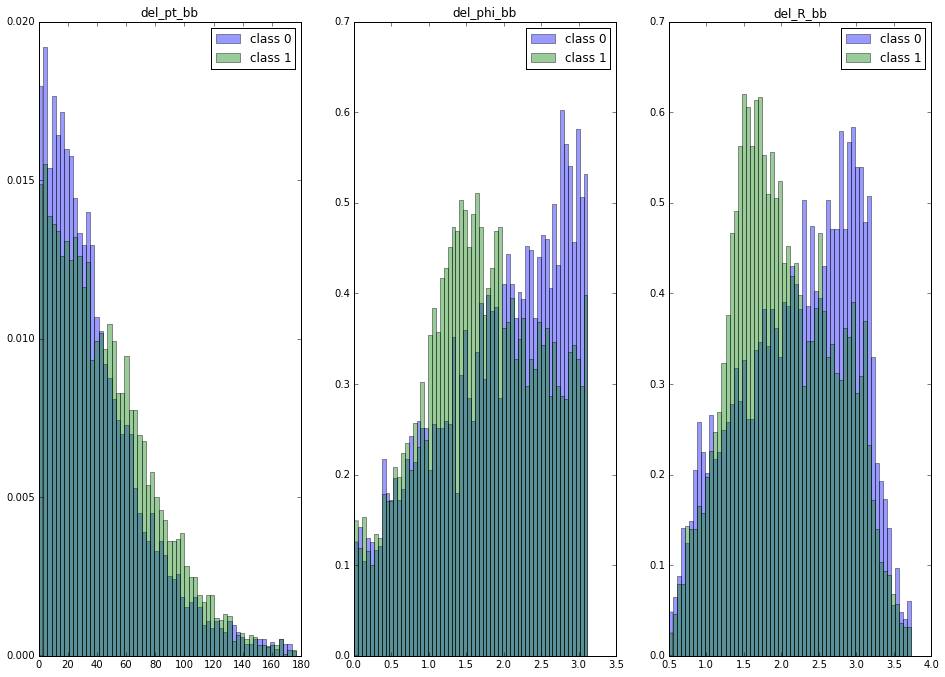

In [43]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}

# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(bjets_selection_fecture):
    # add sub plot on our figure
    plt.subplot(len(bjets_selection_fecture) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

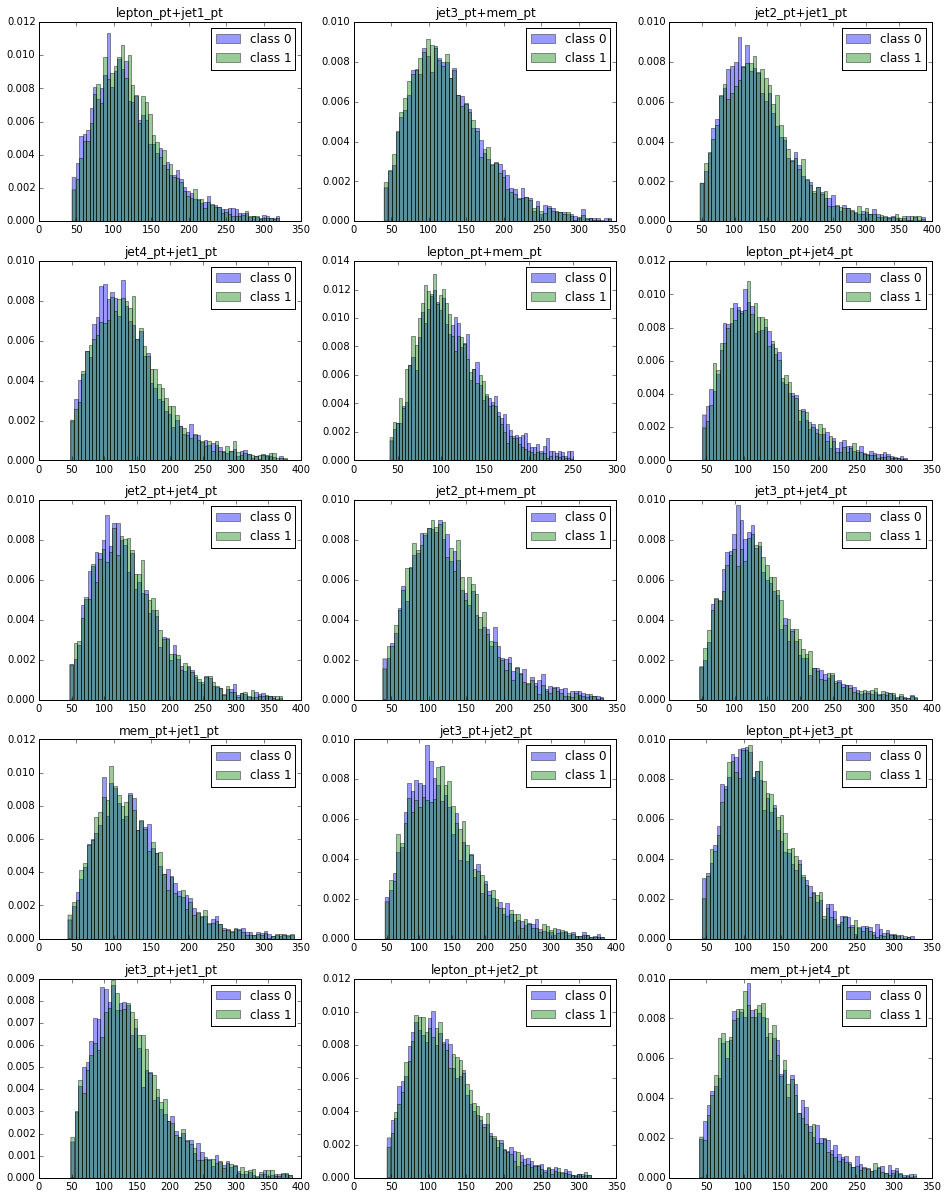

In [18]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}

# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(pair_features):
    # add sub plot on our figure
    plt.subplot(len(pair_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

### Plot histograms for each low-level feature

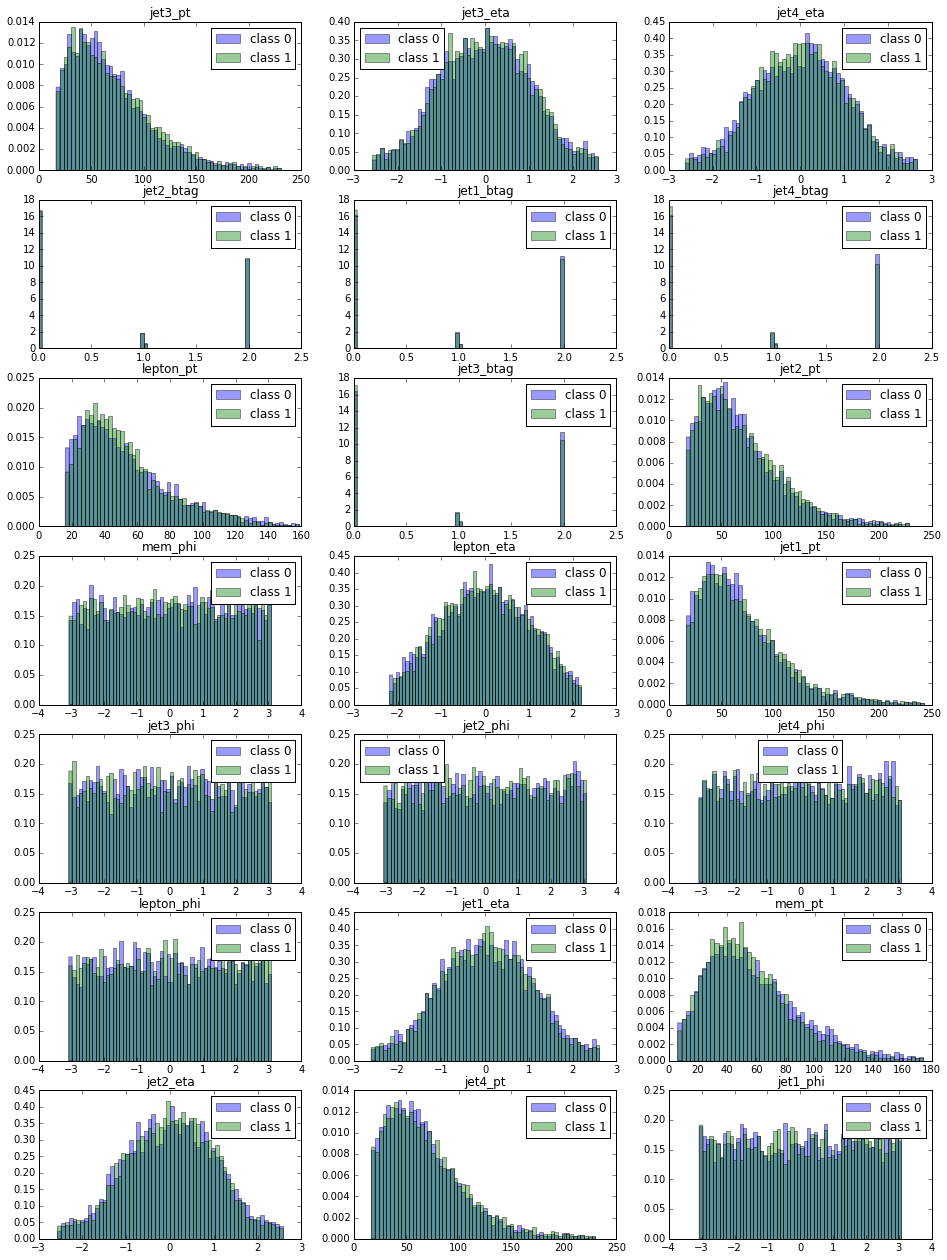

In [19]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(low_level_features):
    # add sub plot on our figure
    plt.subplot(len(low_level_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

### Plot histograms for each high-level feature

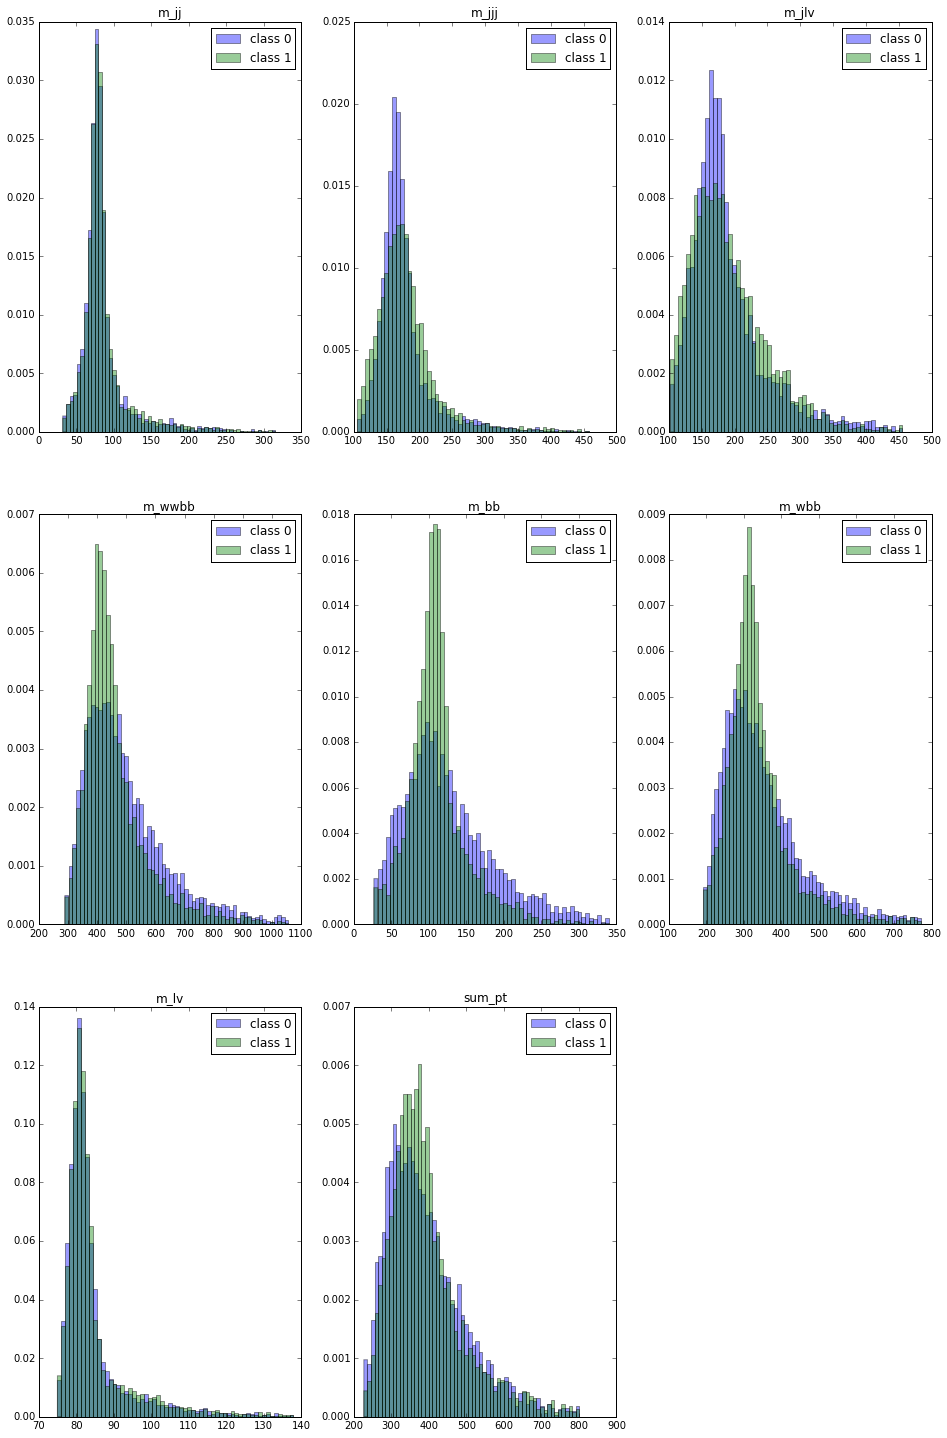

In [20]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(high_level_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.


In [59]:
#training_data, validation_data = train_test_split(data, random_state=11, train_size=0.66)
#training_data
training_data = data.astype(numpy.float64)
training_data

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_btag,jet3_pt,jet3_eta,jet3_phi,jet3_btag,jet4_pt,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,lepton_pt+jet1_pt,jet3_pt+mem_pt,jet2_pt+jet1_pt,jet4_pt+jet1_pt,lepton_pt+mem_pt,lepton_pt+jet4_pt,jet2_pt+jet4_pt,jet2_pt+mem_pt,jet3_pt+jet4_pt,mem_pt+jet1_pt,jet3_pt+jet2_pt,lepton_pt+jet3_pt,jet3_pt+jet1_pt,lepton_pt+jet2_pt,mem_pt+jet4_pt,sum_pt,del_pt_bb,del_phi_bb,del_R_bb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,2.000023,57.689522,-0.161628,-0.682047,0.000000,71.954201,1.154233,-2.858513,2.000016,79.948036,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760,79.564713,92.816635,102.503670,124.762184,55.613003,114.698608,137.637558,78.551956,151.902237,65.676582,129.643723,106.704773,116.768349,92.440094,100.810471,310.018890,27.140053,0.793077,1.541986
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,0.000000,52.221519,-1.094289,-0.252777,2.000023,42.725616,1.474829,2.906143,0.000000,71.681404,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559,85.289963,93.893494,83.260559,102.720444,105.418800,125.932327,123.902924,103.389389,114.407021,82.206909,94.947136,96.976547,73.764656,106.472443,122.849274,303.086365,19.459885,1.047548,1.048506
2,1000003,1,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,0.000000,118.880913,-0.211263,1.326902,0.000000,40.954044,-1.149437,2.123149,1.000011,113.246666,-0.798898,-1.605550,2.000016,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838,84.691338,109.119568,155.826233,150.191986,115.911552,160.992691,232.127579,187.046448,154.200714,105.110840,159.834961,88.700073,77.899353,166.626938,181.412201,425.938507,72.292622,2.554486,2.578425
3,1000004,0,45.950066,1.613817,0.964722,39.302082,-0.075989,84.307426,0.465748,2.287783,2.000016,46.788040,0.441073,-1.303352,0.000000,15.260404,2.409047,-0.850500,0.000000,30.741282,-0.586711,-2.256246,2.000023,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831,130.257492,54.562485,131.095459,115.048706,85.252151,76.691345,77.529320,86.090118,46.001686,123.609512,62.048443,61.210468,99.567833,92.738106,70.043365,262.349304,53.566145,1.739156,2.032815
4,1000005,0,44.409187,-0.228907,-1.837974,49.886654,0.156533,32.852112,2.561646,2.641460,0.000000,46.283184,-1.488267,-2.524357,2.000000,29.664640,-0.031725,-1.192486,0.000000,138.741928,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905,77.261299,79.551292,79.135300,171.594040,94.295837,183.151123,185.025116,96.169838,168.406570,82.738770,75.947823,74.073830,62.516754,90.692368,188.628586,341.837708,13.431072,1.117368,4.201227
5,1000006,1,47.960735,0.113996,1.060799,106.161682,2.015695,60.525757,-0.102381,-2.320091,0.000000,123.111198,0.490156,-1.061288,1.999937,33.649323,0.280342,2.135304,0.000000,42.861736,1.540545,-0.419176,0.000000,77.443741,184.853806,79.668442,140.052399,42.061230,319.923248,412.156982,108.486496,139.811005,183.636963,103.387497,154.122421,90.822472,165.972931,229.272888,76.511063,166.687439,156.760529,81.610062,94.175079,171.071930,149.023422,414.270416,62.585442,1.258803,1.391290
6,1000007,1,46.442108,0.985508,-1.626641,26.800890,-2.045213,53.416817,0.993135,0.138351,0.000000,55.109737,1.250576,3.003202,1.000008,15.932467,1.188875,-0.360576,0.000000,61.113026,-0.641036,1.519797,1.999937,16.887491,153.891785,75.502884,154.074692,145.112534,285.292542,367.908844,99.858925,42.733356,108.526550,114.529846,73.242996,107.555130,116.222763,81.910629,77.045494,80.217705,71.042206,62.374573,69.349281,101.551849,87.913918,258.815033,6.003288,1.483405,2.403890
7,1000008,0,40.197048,0.019778,-3.087664,86.059540,1.251372,90.823509,-0.155913

 # $$ Boosting  for  Higgs  data$$

In [60]:
from rep.estimators import XGBoostClassifier # Use wrapper from Yandex REP by Alexey and Tatiana

In [61]:
# XGBoostClassifier is parrallel inside
xgboost_cv = cross_val_score(XGBoostClassifier(),
                             training_data,
                             training_data["target"].astype(numpy.int64), cv=4, scoring="roc_auc")
print(xgboost_cv.mean(), xgboost_cv.std())

(1.0, 0.0)


In [50]:
#training_data_all_columns = root_pandas.read_root("/notebooks/public_train_10000.root").astype(numpy.float64)
training_data = data[high_level_features]
training_data
training_data_all_columns = training_data.astype(numpy.float64)
features_all_columns = training_data_all_columns[list(set(training_data_all_columns ) - {"target", "event_id"})]
target_all_columns = training_data_all_columns.target.astype(numpy.bool)
#training_data_all_columns.head()

AttributeError: 'DataFrame' object has no attribute 'target'

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
xgb_cv_full = cross_val_score(XGBoostClassifier(n_estimators=100,max_depth = 20), features_all_columns, target_all_columns, cv=4,
                              scoring="roc_auc")
print(xgb_cv_full.mean(), xgb_cv_full.std())

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [24]:
ada_on_xgb = cross_val_score(AdaBoostClassifier(base_estimator=XGBoostClassifier(max_depth = 30)),
                              features_all_columns, target_all_columns, cv=4, scoring="roc_auc")
#ada_on_xgb = cross_val_score(AdaBoostClassifier(base_estimator=XGBoostClassifier()),
#                           features_all_columns, target_all_columns, cv=4, scoring="roc_auc")

print(ada_on_xgb.mean(), ada_on_xgb.std())

NameError: name 'AdaBoostClassifier' is not defined

# AdaBoost over XGBoost. May quite take some time to run.

In [29]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
ada_on_xgb = cross_val_score(AdaBoostClassifier(base_estimator=XGBoostClassifier(max_depth = 30)),
                              features_all_columns, target_all_columns, cv=4, scoring="roc_auc")
#ada_on_xgb = cross_val_score(AdaBoostClassifier(base_estimator=XGBoostClassifier()),
#                           features_all_columns, target_all_columns, cv=4, scoring="roc_auc")

print(ada_on_xgb.mean(), ada_on_xgb.std())

### Compute quality (ROC AUC) on the validation set (to prevent overestimating quality)

In [57]:
# predict validation sample (probability for each event)
proba = knn.predict_proba(validation_data[training_features])
# take probability to be 1 class to compute ROC AUC
roc_auc_score(validation_data.target, proba[:, 1])

0.73082040825375982

## Prepare submission to kaggle

In [58]:
# predict test sample
kaggle_proba = knn.predict_proba(test[low_level_features])[:, 1]
kaggle_ids = test.event_id

ValueError: query data dimension must match training data dimension

In [25]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/notebooks/higgs_kaggle/datasets/baseline.csv